# Выявить определяющие успешность игры закономерности

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

Необходимо выявить определяющие **успешность** игры **закономерности**. 

Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Открываем файл с данными и изучаем общую информацию

**Импорт библиотек и настройки**

In [2]:
from scipy import stats as st

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("whitegrid")

**Загружаем датасет**

In [4]:
data=pd.read_csv('./games.csv')

In [5]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


* присутствуют пропуски
* для Year_of_Release и User_Score необходимо преобразование данных

## Подготавливаем данные

### Заменим название столбцов

In [7]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

приведем к нижнему регистру

In [8]:
new_names = list(map(lambda x: x.lower(),data.columns))

проведем замену

In [9]:
data.set_axis(new_names,axis = 'columns',inplace = True)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработаем пропуски и преобразуем типы данных

общий взгляд на кол-во пропусков

In [10]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.010000
platform,0.000000
year_of_release,1.610000
genre,0.010000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.320000
user_score,40.090000


#### name

In [11]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


пропусков очень малое кол-во (2). удалим.

In [12]:
data.dropna(subset = ['name'], inplace = True)
data['name'].isna().sum()

0

#### year_of_release

In [13]:
data['year_of_release'].isna().mean()

0.016095255190570215

In [14]:
data[data['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


пропусков незначительное кол-во (<2%). удалим.

In [15]:
data.dropna(subset = ['year_of_release'], inplace = True)
data['year_of_release'].isna().sum()

0

столбец преобразуем в `int`

In [16]:
data['year_of_release']=data['year_of_release'].astype('int')
data['year_of_release'].dtypes

dtype('int64')

#### critic_score

In [17]:
data['critic_score'].isna().sum()

8461

In [18]:
data[data['critic_score'].isna()].sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16422,Jam Sessions: Sing and Play Guitar (jp sales),DS,2007,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
3332,MonHun Nikki: Poka Poka Ailu Mura,PSP,2010,Role-Playing,0.00,0.00,0.60,0.00,NaN,NaN,NaN
13206,Hotel for Dogs,Wii,2009,Simulation,0.04,0.00,0.00,0.00,NaN,tbd,E
12130,Firefighter F.D.18,PS2,2004,Action,0.03,0.03,0.00,0.01,NaN,NaN,NaN
12004,Cut the Rope,3DS,2014,Puzzle,0.06,0.00,0.00,0.01,NaN,tbd,E


больше половина значений имею пропуск. оставляем как есть.

#### user_score

In [19]:
data['user_score'].isna().sum()

6605

значительное кол-во значений (40%) имею пропуск. оставляем как есть.

In [20]:
data[data['user_score']=='tbd']['user_score'].count()

2376

tbd - to be determined, будет определено.

<div class="alert alert-info">
    
значение tbd переведем в NaN</div>

In [21]:
data['user_score'].replace('tbd', np.nan, inplace=True)

In [22]:
data['user_score'].isna().sum()

8981

переведем строковые значения в числа

In [23]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='ignore')

#### rating

In [25]:
data['rating'].isna().sum()

6676

In [26]:
data[data['rating'].isna()].sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15757,Nobunaga no Yabou: Soutensoku with Power-Up Kit,PSP,2011,Strategy,0.00,0.00,0.02,0.00,NaN,NaN,NaN
8370,Hot Wheels: Beat That!,X360,2007,Racing,0.15,0.00,0.00,0.01,NaN,NaN,NaN
11070,Porsche Challenge,PS,1997,Racing,0.05,0.03,0.00,0.01,NaN,NaN,NaN
1935,Hot Wheels Turbo Racing,PS,1999,Racing,0.59,0.40,0.00,0.07,NaN,NaN,NaN
5397,Carnival,2600,1981,Shooter,0.32,0.02,0.00,0.00,NaN,NaN,NaN


значительное кол-во значений имею пропуск (около 40%). оставляем как есть.

In [27]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

In [28]:
data.loc[data['rating']=='K-A']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997,Strategy,2.30,0.10,0.00,0.00,NaN,9.0,K-A
903,PaRappa The Rapper,PS,1996,Misc,0.26,0.16,1.46,0.03,92.0,7.4,K-A
16681,Worms 2,PC,1997,Strategy,0.00,0.01,0.00,0.00,NaN,8.1,K-A


K-A рейтинг использовался до 1998 затем был переименован в E.

In [29]:
data.loc[data['rating']=='K-A','rating'] = 'E'

### Рассчет суммарных продаж

сумарные продажи добавим новым столбцом

In [30]:
data['sales_sum']=data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
data['sales_sum']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: sales_sum, Length: 16444, dtype: float64

## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы

In [31]:
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

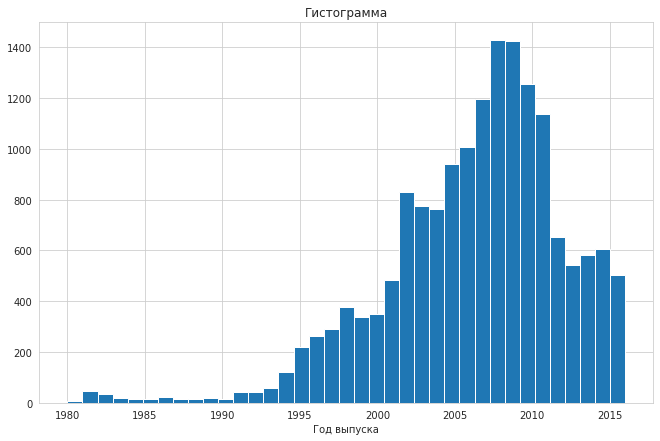

In [32]:
plt.figure(figsize=(11, 7))
data['year_of_release'].hist(bins=len(data['year_of_release'].unique()))
plt.xlabel('Год выпуска')
plt.title('Гистограмма')
plt.show()

* для анализа на будущий год, важными данными считаю за период 10-15 лет (2015-2000 гг)

<div class="alert alert-info">
<ul>
    <li>кол-во игр расспределено нормально и имеет скошенность влево </li>
    <li>Наибольшее кол-во выпускаемых игр (пик) приходится на период 2007-2010 гг.</li>
</ul>
</div>

### Как менялись продажи по платформам

выберем платформы с наибольшими суммарными продажами, топ-7

In [33]:
sales_sum_top = data\
    .pivot_table(index='platform', values='sales_sum',aggfunc=sum)\
    .sort_values(by='sales_sum',ascending=False)\
    .head(7)
sales_sum_top

,sales_sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14


сделаем срез данных по топовым платформам

In [34]:
data_top = data.query('platform in @sales_sum_top.index')
data_top.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


сформируем таблицу с суммарными продажами по годам для топ платформ

In [35]:
d1=data_top.pivot_table(index='platform',columns=['year_of_release'],values='sales_sum',aggfunc='sum').reset_index()
d1

year_of_release,platform,1985,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,DS,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.27,130.14,119.81,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
1,PS,NaN,6.03,35.96,94.7,136.17,169.49,144.53,96.37,35.59,6.67,2.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.17,166.43,205.38,184.31,211.81,160.66,103.42,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
3,PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
4,PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25
5,Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
6,X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.25,51.62,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52


перевернем таблицу с продажами

In [36]:
d1=d1.melt('platform')
d1

,platform,year_of_release,value
0,DS,1985,0.02
1,PS,1985,NaN
2,PS2,1985,NaN
3,PS3,1985,NaN
4,PS4,1985,NaN
...,...,...,...
163,PS2,2016,NaN
164,PS3,2016,3.60
165,PS4,2016,69.25
166,Wii,2016,0.18


построим график продаж по годам для топовых платформ

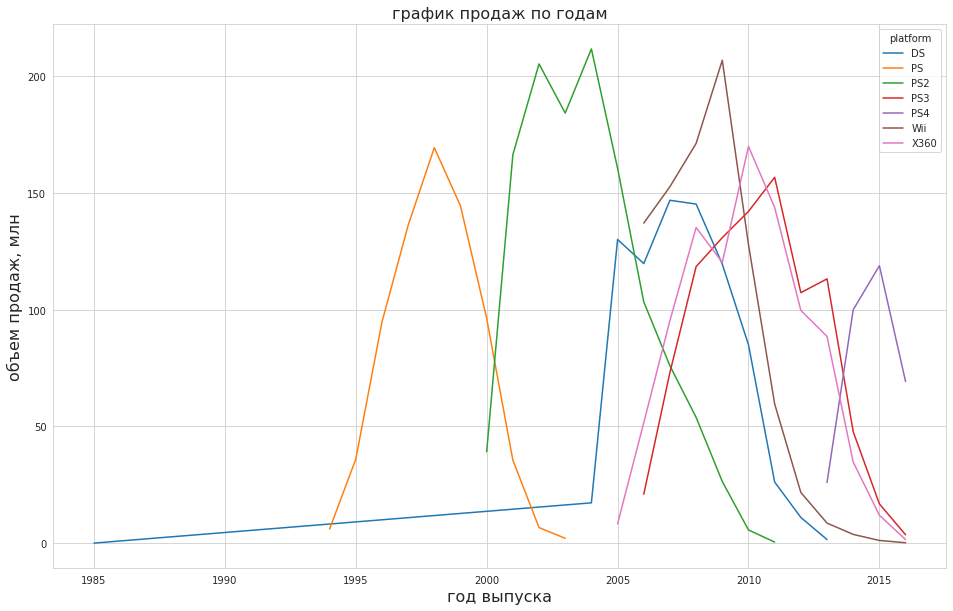

In [37]:
plt.figure(figsize=(16, 10))
sns.lineplot(
    x='year_of_release',
    y='value',
    hue='platform',
    data=d1)
plt.title('график продаж по годам',fontsize=16)
plt.xlabel('год выпуска',fontsize=16)
plt.ylabel('объем продаж, млн',fontsize=16)
plt.show()

* На графике можно выделить период от 7 до 10 лет за который продажи для платформы выростают и затухают.

<div class="alert alert-info">
сравним средние продолжитеьности жизни у топ платформ и всех
</div>

уберем ошибку для платформы DS

In [38]:
data[(data['platform']=='DS')&(data['year_of_release']==1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


у Strongest Tokyo University Shogi DS год редиза 2010. исправим

In [39]:
data.loc[(data['platform']=='DS')&(data['year_of_release']==1985),'year_of_release']=2010

посчитаем среднее для топ платформ и всех

In [40]:
periods_top = []
for p in sales_sum_top.index:
    period=data[data['platform']==p]['year_of_release'].max()-data[data['platform']==p]['year_of_release'].min()
    periods_top.append(period)
periods_top_mean = sum(periods_top)/len(periods_top)

In [41]:
periods_all = []
for p in data['platform'].unique():
    period=data[data['platform']==p]['year_of_release'].max()-data[data['platform']==p]['year_of_release'].min()
    periods_all.append(period)
periods_all_mean = sum(periods_all)/len(periods_all)

In [42]:
print('Средняя продолжительность жизни популярных платформ:',periods_top_mean)
print('Средняя продолжительность жизни всех платформ:', periods_all_mean)

Средняя продолжительность жизни популярных платформ: 9.0
Средняя продолжительность жизни всех платформ: 7.0


### Определение актуального периода

<div class="alert alert-info">
актуальный период возьмем 4 года, т.к. 2016 неполный
</div>

In [43]:
PERIOD = 4

данные за период в отдельный датафрейм `data_rsch`.

In [44]:
data_rsch = data[data['year_of_release'] > (data['year_of_release'].max() - PERIOD) ]
data_rsch.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [45]:
data_rsch['year_of_release'].min()

2013

### Платформы лидеры

сформируем срез с суммарными продажами за актуальный период исследования

In [46]:
d2=data_rsch.pivot_table(index='platform',columns=['year_of_release'],values='sales_sum',aggfunc='sum').reset_index()
d2=d2.melt('platform')
d2.head()

,platform,year_of_release,value
0,3DS,2013,56.57
1,DS,2013,1.54
2,PC,2013,12.38
3,PS3,2013,113.25
4,PS4,2013,25.99


построим график продаж

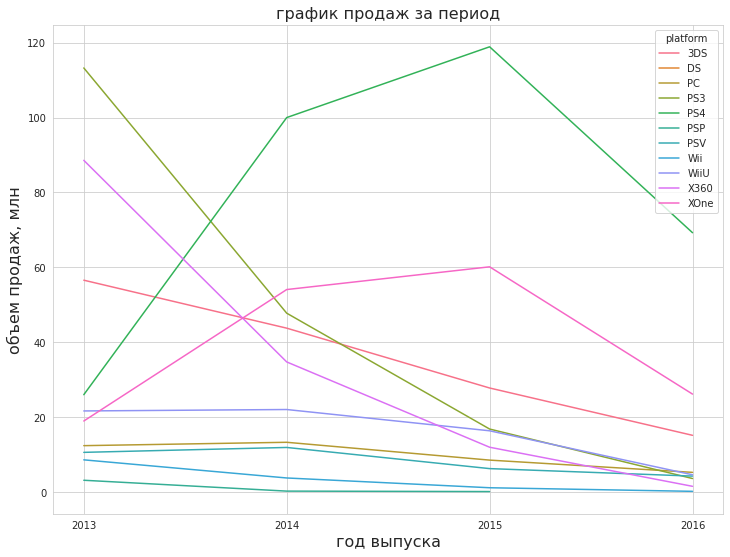

In [47]:
plt.figure(figsize=(12, 9))
sns.lineplot(
    x='year_of_release',
    y='value',
    hue='platform',
    data=d2
)
plt.title('график продаж за период',fontsize=16)
plt.xlabel('год выпуска',fontsize=16)
plt.ylabel('объем продаж, млн',fontsize=16)
plt.xticks([2013, 2014, 2015, 2016])
plt.show()

* потенциально прибыльные платформы PS4, XOne, т.к. у них присутствует рост за 2015 год (2016 можно не учитывать т.к. данные неполные)

### график «ящик с усами» по глобальным продажам игр

Построим диаграмму размаха по глобальным продажам игр в разбивке по платформам

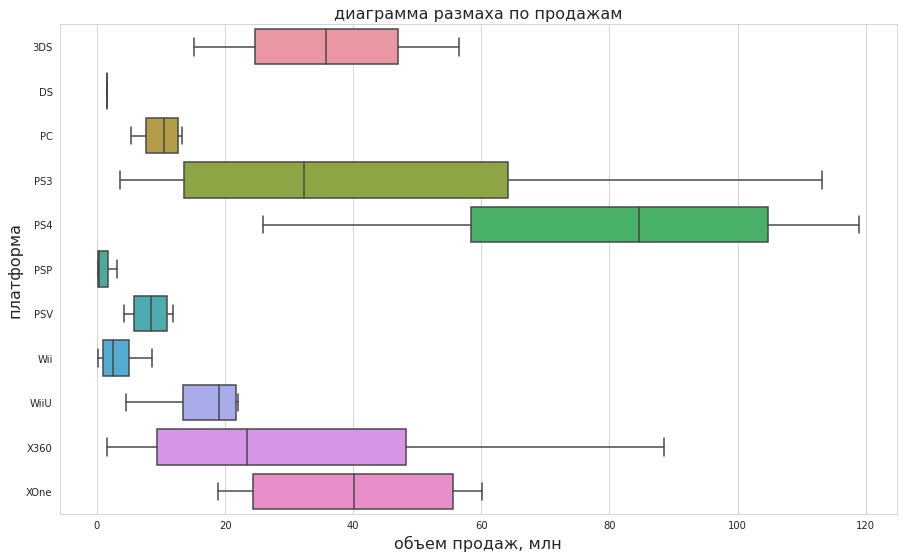

In [48]:
plt.figure(figsize=(15, 9))
sns.boxplot(y='platform', x='value', data = d2, orient='h')
plt.title('диаграмма размаха по продажам',fontsize=16)
plt.xlabel('объем продаж, млн',fontsize=16)
plt.ylabel('платформа',fontsize=16)
plt.show()

<div class="alert alert-info">
вывод немного изменился, т.к. поменялся актуальный период (был 7 лет, стал 4 года) 
</div>

* смещение объема продаж в большую сторону: PS4
* наибольшая медиана: XOne, PS4
* объем продаж: PS4, PS3
* наибольший межквартильный размах: PS4, PS3 
* наименьшие продажи: DS, PSP


### влияние на продажи внутри одной платформы отзывов пользователей и критиков

в качестве популярной платформы выберем PS3

In [49]:
data_ps3=data_rsch.loc[data_rsch['platform']=='PS3',['critic_score','user_score','sales_sum']]
data_ps3.head()

,critic_score,user_score,sales_sum
16,97.0,8.2,21.05
69,71.0,2.6,9.36
126,86.0,4.3,6.46
149,95.0,9.1,5.86
180,NaN,NaN,5.27


построим матрицу диаграмм рассеяния зависимости оценок и продаж

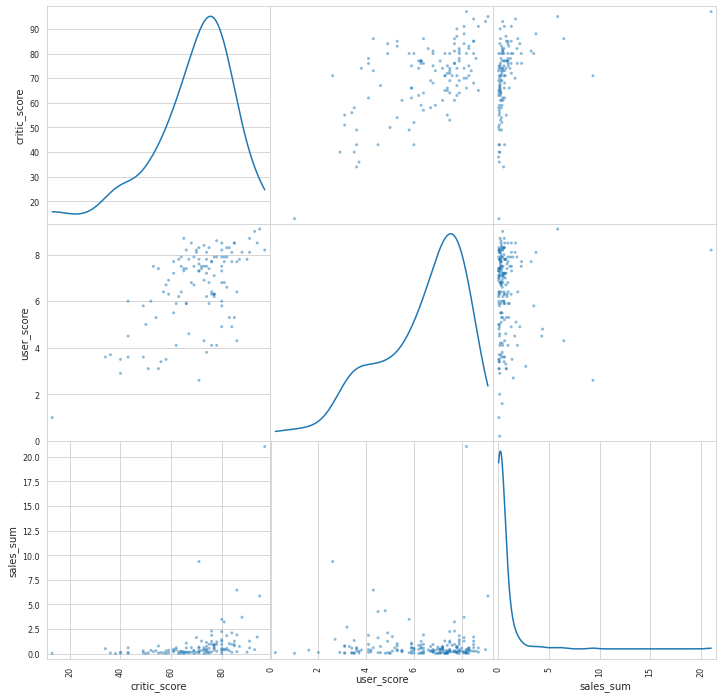

In [50]:
pd.plotting.scatter_matrix(
    data_ps3, 
    figsize=(12, 12),
    diagonal='kde'
)
plt.show()

построим матрицу корреляции, чтобы посмотреть влияние отзывов на продажи

In [51]:
# расчет коэффициента Пирсона
corr=data_ps3.corr()
corr.style.background_gradient(cmap='coolwarm')

,critic_score,user_score,sales_sum
critic_score,1.000000,0.599920,0.334285
user_score,0.599920,1.000000,0.002394
sales_sum,0.334285,0.002394,1.000000


* слабая связь между отзывами критиков и продажами
* между отзывами пользователей и продажами связи почти нет
* умеренная связь между отзывами критиков и пользователей

### График зависимости продаж от оценок между прибыльными платформами

потенциально прибыльные платформы:PS4, XOne, 3DS 

In [52]:
data_top3=data_rsch.loc[(data_rsch['platform']=='PS4')|(data_rsch['platform']=='XOne')|(data_rsch['platform']=='3DS'),
                        ['platform','critic_score','user_score','sales_sum']]
data_top3.head()

,platform,critic_score,user_score,sales_sum
31,PS4,NaN,NaN,14.63
33,3DS,NaN,NaN,14.60
42,PS4,97.0,8.3,12.62
47,3DS,NaN,NaN,11.68
77,PS4,82.0,4.3,8.58


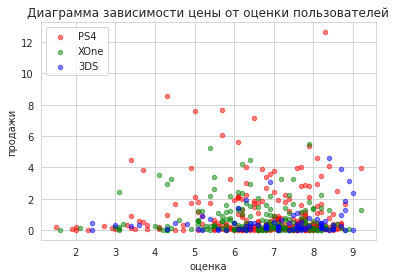

In [53]:
ax=data_top3[data_top3['platform']=='PS4'].plot(
    y='sales_sum',
    x='user_score', 
    kind='scatter',
    color='red',
    label='PS4',
    alpha=.5
)
data_top3[data_top3['platform']=='XOne'].plot(
    y='sales_sum',
    x='user_score',
    kind='scatter',
    color='green',
    label='XOne',
    alpha=.5,
    ax=ax
)
data_top3[data_top3['platform']=='3DS'].plot(
    y='sales_sum',
    x='user_score',
    kind='scatter',
    color='blue',
    label='3DS',
    alpha=.5,
    ax=ax
)
plt.title('Диаграмма зависимости цены от оценки пользователей')
plt.xlabel('оценка')
plt.ylabel('продажи')
plt.show()

* для платформы 3DS зависимость от оценки выше чем у остальных платформ

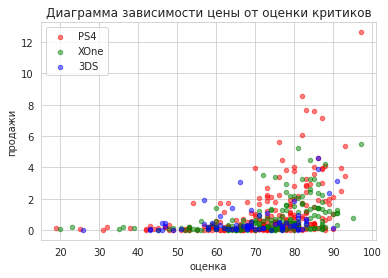

In [54]:
ax=data_top3[data_top3['platform']=='PS4'].plot(
    y='sales_sum',
    x='critic_score', 
    kind='scatter',
    color='red',
    label='PS4',
    alpha=.5
)
data_top3[data_top3['platform']=='XOne'].plot(
    y='sales_sum',
    x='critic_score',
    kind='scatter',
    color='green',
    label='XOne',
    alpha=.5,
    ax=ax
)
data_top3[data_top3['platform']=='3DS'].plot(
    y='sales_sum',
    x='critic_score',
    kind='scatter',
    color='blue',
    label='3DS',
    alpha=.5,
    ax=ax
)
plt.title('Диаграмма зависимости цены от оценки критиков')
plt.xlabel('оценка')
plt.ylabel('продажи')
plt.show()

* для платформ заметна зависимость продаж от оценки критиков 

<div class="alert alert-info">
расчет коэффициента корреляции для потенциально прибыльных платформ.
    
присутствует слабая зависимость между оценкой критиков и продажами 
</div>

In [55]:
data_top3['user_score'].corr(data_top3['sales_sum'])

-0.013552015554771302

In [56]:
data_top3['critic_score'].corr(data_top3['sales_sum'])

0.3923796478002085

### общее распределение игр по жанрам

#### суммарные продажи игр по жанрам и игровым платформам

построим "тепловую карту" продаж по играм и платформам 

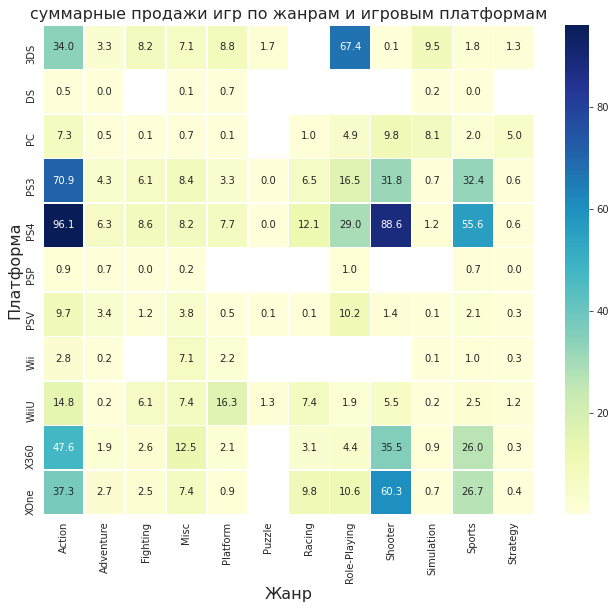

In [57]:
plt.figure(figsize=(11, 9))
sns.heatmap(
    data_rsch.pivot_table(index='platform',columns='genre',values='sales_sum',aggfunc=sum),
    annot=True,
    fmt='.1f',
    linewidths=.5,
    cmap="YlGnBu"
)
plt.title('суммарные продажи игр по жанрам и игровым платформам',fontsize=16)
plt.xlabel('Жанр',fontsize=16)
plt.ylabel('Платформа',fontsize=16)
plt.show()

* прибыльные жанры: Action, Shooter, Sports
* низкие продажи: Puzzle, Strategy

#### График суммы продаж по жанрам

<div class="alert alert-info">
построим столбчатый график суммы продаж по жанрам
</div>

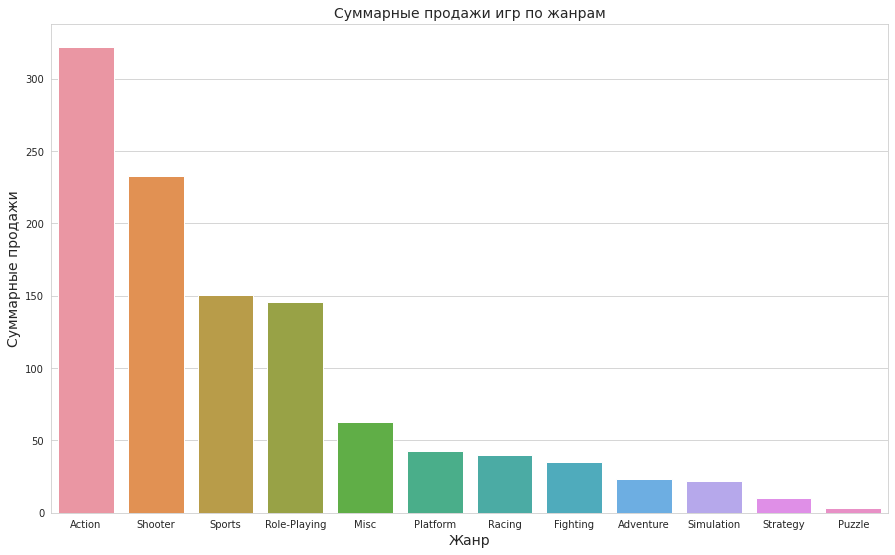

In [58]:
plt.figure(figsize=(15, 9))
sns.barplot(
    data=data_rsch.pivot_table(
        index='genre',
        values='sales_sum',
        aggfunc=sum).reset_index().sort_values(
            by='sales_sum',
            ascending = False),
    x='genre',
    y='sales_sum'
)
plt.title('Суммарные продажи игр по жанрам',fontsize=14)
plt.xlabel('Жанр',fontsize=14)
plt.ylabel('Суммарные продажи',fontsize=14)
plt.show()

## Портрет пользователя каждого региона (NA, EU, JP)

In [59]:
#устанавливаем шрифты для различных элементов графика
plt.rc('xtick', labelsize=14)
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=14)

In [60]:
#словарь регионов
regions={'NA':'na_sales','EU':'eu_sales','JP':'jp_sales'}

### Самые популярные платформы (топ-5)

#### ТОП глобальный

собираем топ-5 платформ

In [61]:
platform_top5 = data_rsch.pivot_table(
    index='platform',
    values='sales_sum',
    aggfunc='sum'
    ).sort_values(
        by='sales_sum',
        ascending = False
    ).head(5).index.values
platform_top5

array(['PS4', 'PS3', 'XOne', '3DS', 'X360'], dtype=object)

сформируем срез данных для топ-5 платформ

In [62]:
data_top5_p = data_rsch.query('platform in @platform_top5')
data_top5_p.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


нарисуем график баров

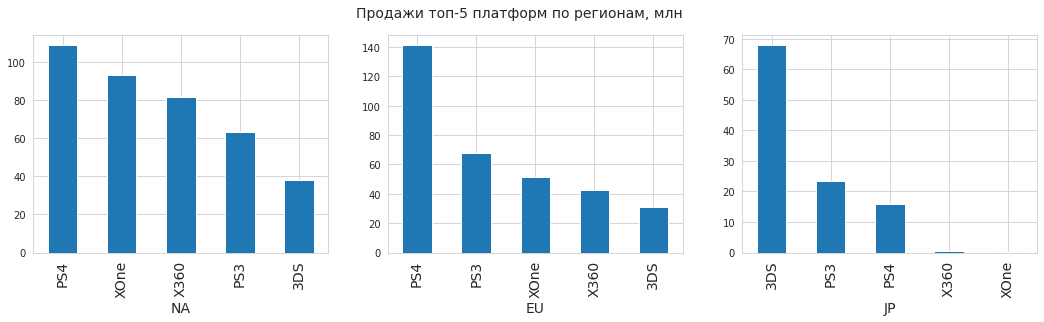

In [63]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи топ-5 платформ по регионам, млн')
i=0
for key, value in regions.items():
    (
        data_top5_p.pivot_table(index='platform', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* самые высокие продажы в регионе EU, лидирует PS4
* лидеры платформы для NA и EU совпадают
* самые низкие продажи в JP у X360 и XOne
* обратим внимание на сумму продаж для PS3 и PS4 (один производитель)   

#### ТОП по регионам

<div class="alert alert-info">
построим графики для регионов со своими топ платформами
</div>

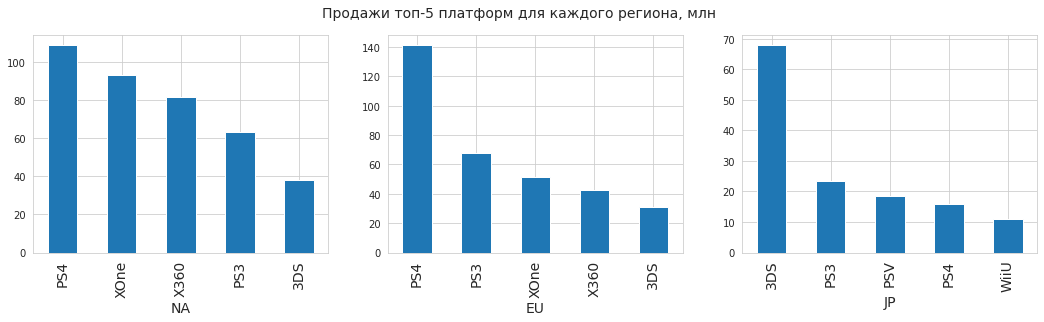

In [64]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи топ-5 платформ для каждого региона, млн')
i=0
for key, value in regions.items():
    (
        data_rsch.pivot_table(index='platform', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .head(5)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* самые высокие продажы в регионе EU, лидирует PS4
* лидер для NA и EU совпадает
* самые низкие продажи в JP у WiiU
* XOne и X360 в регионе JP не вошли в топ

#### Расчет долей

<div class="alert alert-info">
посчитаем ДОЛИ продаж платформ из ТОПа от остальных топовых платформ по региону
</div>

сформируем топ5 по всем регионам за актуальный период 

In [65]:
top5_sales =data_rsch.pivot_table(
    index='platform',
    values='sales_sum',
    aggfunc='sum'
    ).sort_values(
        by='sales_sum',
        ascending = False
    ).head(5).reset_index()

In [66]:
# на входе регион (столбец)
# на выходе топ5 по региону

def make_top5_sales_reg(reg):
    top5_sales_reg=data_rsch.pivot_table(
        index='platform',
        values=reg,
        aggfunc='sum'
        ).sort_values(by=reg, ascending=False).head(5).reset_index()
    return top5_sales_reg


сводим в общую таблицу

In [67]:
top5_sales=top5_sales.merge(make_top5_sales_reg('na_sales'),on='platform', how='left')
top5_sales=top5_sales.merge(make_top5_sales_reg('eu_sales'),on='platform', how='left')
top5_sales=top5_sales.merge(make_top5_sales_reg('jp_sales'),on='platform', how='left')

top5_sales

,platform,sales_sum,na_sales,eu_sales,jp_sales
0,PS4,314.14,108.74,141.09,15.96
1,PS3,181.43,63.50,67.81,23.35
2,XOne,159.32,93.12,51.59,NaN
3,3DS,143.25,38.20,30.96,67.81
4,X360,136.80,81.66,42.52,NaN


расчитываем доли продаж платформы по каждому региону

In [68]:
top5_sales['na_share']=top5_sales['na_sales']/top5_sales['sales_sum']
top5_sales['eu_share']=top5_sales['eu_sales']/top5_sales['sales_sum']
top5_sales['jp_share']=top5_sales['jp_sales']/top5_sales['sales_sum']

top5_sales

,platform,sales_sum,na_sales,eu_sales,jp_sales,na_share,eu_share,jp_share
0,PS4,314.14,108.74,141.09,15.96,0.346151,0.449131,0.050805
1,PS3,181.43,63.50,67.81,23.35,0.349997,0.373753,0.128700
2,XOne,159.32,93.12,51.59,NaN,0.584484,0.323814,NaN
3,3DS,143.25,38.20,30.96,67.81,0.266667,0.216126,0.473368
4,X360,136.80,81.66,42.52,NaN,0.596930,0.310819,NaN


* PS4 и PS3 больше лучше продаются в EU
* XOne лучше продается в NA
* лидером продаж в JP является 3DS

#### Расчет долей внутри региона

<div class="alert alert-info">
 добавил расчет долей внутри региона
</div>

**NA**

In [69]:
top5_sales_na = make_top5_sales_reg('na_sales')
top5_sales_na

,platform,na_sales
0,PS4,108.74
1,XOne,93.12
2,X360,81.66
3,PS3,63.50
4,3DS,38.20


In [70]:
top5_sales_na['na_share'] = top5_sales_na['na_sales']/top5_sales_na['na_sales'].sum()
top5_sales_na

,platform,na_sales,na_share
0,PS4,108.74,0.282280
1,XOne,93.12,0.241732
2,X360,81.66,0.211983
3,PS3,63.50,0.164841
4,3DS,38.20,0.099164


* треть дохода приносит PS4
* платформы от microsoft (XOne,X360) приносят столько же прибыли как и платформы от SONY (PS4,PS3)

**EU**

In [71]:
top5_sales_eu = make_top5_sales_reg('eu_sales')
top5_sales_eu

,platform,eu_sales
0,PS4,141.09
1,PS3,67.81
2,XOne,51.59
3,X360,42.52
4,3DS,30.96


In [72]:
top5_sales_eu['eu_share'] = top5_sales_eu['eu_sales']/top5_sales_eu['eu_sales'].sum()
top5_sales_eu

,platform,eu_sales,eu_share
0,PS4,141.09,0.422463
1,PS3,67.81,0.203042
2,XOne,51.59,0.154475
3,X360,42.52,0.127317
4,3DS,30.96,0.092703


* около половины продаж приносит PS4

**JP**

In [73]:
top5_sales_jp = make_top5_sales_reg('jp_sales')
top5_sales_jp

,platform,jp_sales
0,3DS,67.81
1,PS3,23.35
2,PSV,18.59
3,PS4,15.96
4,WiiU,10.88


In [74]:
top5_sales_jp['jp_share'] = top5_sales_jp['jp_sales']/top5_sales_jp['jp_sales'].sum()
top5_sales_jp

,platform,jp_sales,jp_share
0,3DS,67.81,0.496449
1,PS3,23.35,0.170950
2,PSV,18.59,0.136101
3,PS4,15.96,0.116846
4,WiiU,10.88,0.079654


* основная прибыль от платформы Nintendo 3DS

### Самые популярные жанры (топ-5)

#### ТОП глобальный

собираем топ-5 жанров

In [75]:
genre_top5 = data_rsch.pivot_table(
    index='genre',
    values='sales_sum',
    aggfunc='sum'
    ).sort_values(
        by='sales_sum',
        ascending = False
    ).head(5).index.values
genre_top5

array(['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc'],
      dtype=object)

сформируем срез данных для топ-5 жанров

In [76]:
data_top5_g = data_rsch.query('genre in @genre_top5')
data_top5_g.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


нарисуем график баров


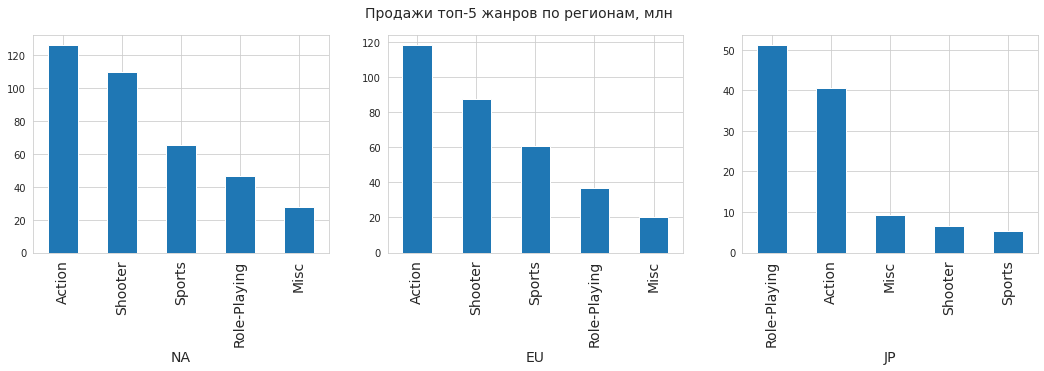

In [77]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи топ-5 жанров по регионам, млн')
i=0
for key, value in regions.items():
    (
        data_top5_g.pivot_table(index='genre', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* лидером по продажам является жанр Action, следующий Shooter 
* наибольшие продажи в регионах NA и EU
* в регионе JP лидером является Role-Playing. Объем продаж по этому жанру совпадает для NA и JP

#### ТОП по регионам

<div class="alert alert-info">
построим графики для регионов со своими топ жанрами
</div>

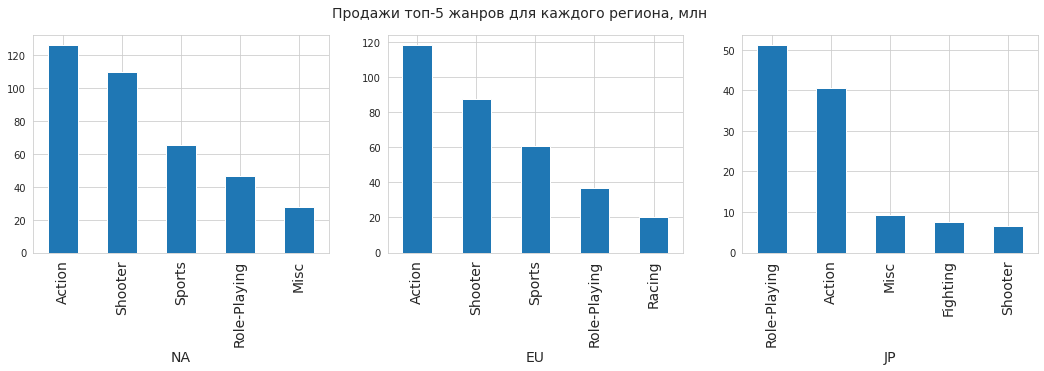

In [78]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи топ-5 жанров для каждого региона, млн')
i=0
for key, value in regions.items():
    (
        data_rsch.pivot_table(index='genre', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .head(5)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* лидером по продажам является жанр Action, следующий Shooter 
* наибольшие продажи в регионах NA и EU
* в регионе JP лидером является Role-Playing

### Влияние рейтинга ESRB на продажи

#### ТОП глобальный

сформируем список рейтингов с сортировкой по продажам

In [79]:
rating = data_rsch.pivot_table(
    index='rating',
    values='sales_sum',
    aggfunc='sum'
    ).sort_values(
        by='sales_sum',
        ascending = False
    ).index.values
rating

array(['M', 'E', 'T', 'E10+'], dtype=object)

нарисуем график баров

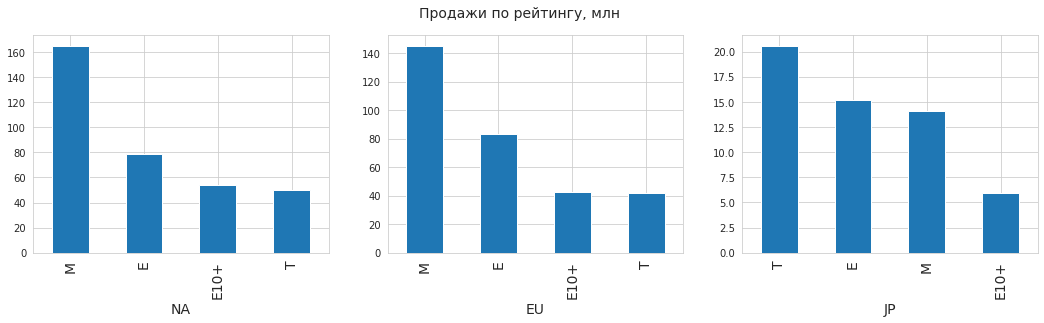

In [80]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи по рейтингу, млн')
i=0
for key, value in regions.items():
    (
        data_rsch.pivot_table(index='rating', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* наибольший доход приносят игры с рейтингом М (Материалы игры не подходят для подростков младше 17 лет) и Е («Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.)

#### ТОП по регионам

<div class="alert alert-info">
построим графики для регионов со своим топ
</div>

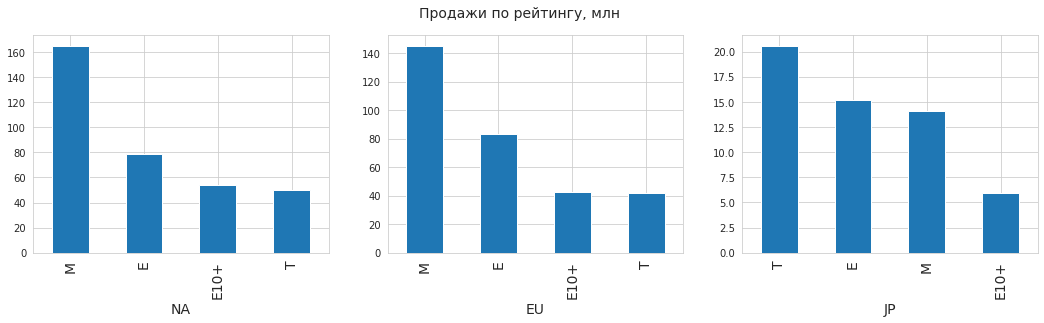

In [81]:
fig, axes = plt.subplots(1, 3, figsize = (18,4))

fig.suptitle('Продажи по рейтингу, млн')
i=0
for key, value in regions.items():
    (
        data_rsch.pivot_table(index='rating', values=value, aggfunc='sum')
        .sort_values(by=value, ascending=False)
        .head(5)
        .plot(kind='bar',ax = axes[i])
        .set(xlabel=key)
    )
    axes[i].get_legend().remove()
    i+=1
plt.show()

* наибольший доход приносят игры с рейтингом М (Материалы игры не подходят для подростков младше 17 лет) и Е («Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.)
* для региона JP рейтинг T ("Подросткам")

## Проверяем гипотезы

установим критический уровень статистической значимости

In [82]:
alpha = .05 

используем срез данных за актуальный период 

In [83]:
data_rsch.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


### Средние пользовательские оценки платформ Xbox One и PC одинаковые

* Нулевая гипотеза H0: Средние пользовательские оценки платформ Xbox One и PC **совпадают**
* Альтернативная гипотеза H1: Средние пользовательские оценки платформ Xbox One и PC **различаются**

#### построим гистограммы оценок по платформам

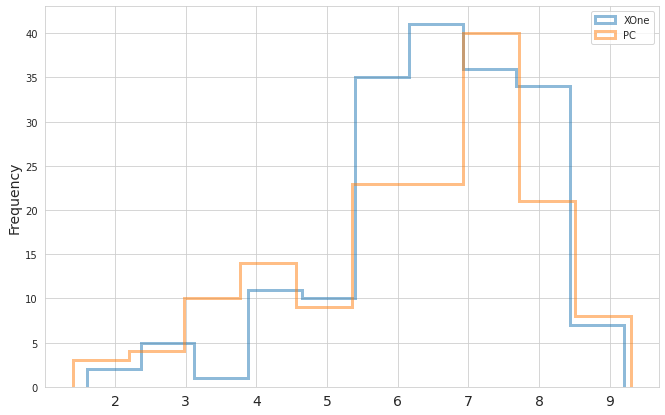

In [84]:
plt.figure(figsize=(11, 7))
ax = data_rsch[data_rsch['platform']=='XOne']['user_score'].plot.hist(
    histtype='step',alpha=.5,linewidth=3,label='XOne',legend=True)
data_rsch[data_rsch['platform']=='PC']['user_score'].plot.hist(
    histtype='step',ax=ax,alpha=.5,linewidth=3,label='PC',legend=True)
plt.show()

создадим срезы без пропущенных значений (nan)

In [85]:
user_score_xone = data_rsch[(data_rsch['platform']=='XOne')& (~data_rsch['user_score'].isna())& (data_rsch['user_score']!=0)]['user_score']
user_score_pc = data_rsch[(data_rsch['platform']=='PC')&(~data_rsch['user_score'].isna())&(data_rsch['user_score']!=0)]['user_score']

#### рассчитаем дисперсии для параметра equal_var

In [86]:
np.var(user_score_xone)

1.8965188383045533

In [87]:
np.var(user_score_pc)

3.0163063475546332

дисперсии отличаются, установим equal_var = False

#### проверка гипотезы

In [88]:
results = st.ttest_ind(user_score_xone, user_score_pc,equal_var = False)
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info">
"Человеческий язык": Пользователи оценивают игры на платформах Xbox One и PC в среднем одинаково 
</div>

### Средние пользовательские оценки жанров Action и Sports разные

* Нулевая гипотеза H0: Средние пользовательские оценки жанров Action и Sports **совпадают**
* Альтернативная гипотеза H1: Средние пользовательские оценки жанров Action и Sports **различаются**

#### построим гистограммы оценок по жанрам

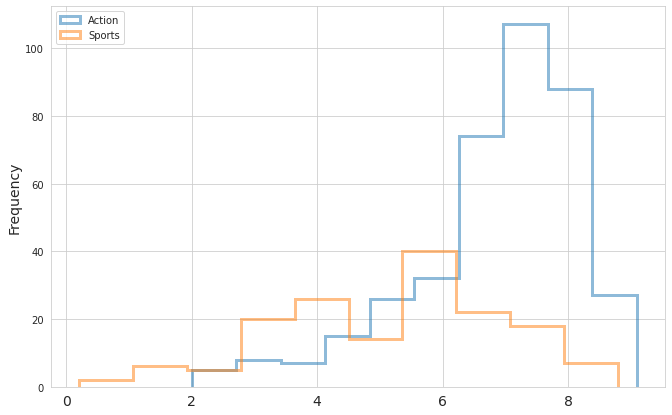

In [89]:
plt.figure(figsize=(11, 7))
ax = data_rsch[data_rsch['genre']=='Action']['user_score'].plot.hist(
    histtype='step',alpha=.5,linewidth=3,label='Action',legend=True)
data_rsch[data_rsch['genre']=='Sports']['user_score'].plot.hist(
    histtype='step',ax=ax,alpha=.5,linewidth=3,label='Sports',legend=True)
plt.show()

создадим срезы без пропущенных значений (nan)

In [90]:
user_score_action = data_rsch[(data_rsch['genre']=='Action')& (~data_rsch['user_score'].isna())& (data_rsch['user_score']!=0)]['user_score']
user_score_sports = data_rsch[(data_rsch['genre']=='Sports')&(~data_rsch['user_score'].isna())& (data_rsch['user_score']!=0)]['user_score']

#### рассчитаем дисперсии для параметра equal_var

In [91]:
np.var(user_score_action)

1.764812418633236

In [92]:
np.var(user_score_sports)

3.1607339843749975

дисперсии отличаются, установим equal_var = False

#### проверка гипотезы

In [93]:
results = st.ttest_ind(user_score_action, user_score_sports,equal_var = False)
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


<div class="alert alert-info">
"Человеческий язык": Пользователи оценивают жанры Action и Sports в среднем поразному 
</div>

## Общий вывод

**Обзор проведенной работы**: В работе был проведен предварительный анализ данных о продажах и оценках компьютерных игр.
1. Изучены имеющиеся данные: доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы
2. Проведена предобработка данных:
* перевод строк в числовое значение
* выявлено большое кол-во пропусков
* рассчитаны суммарные продажи для игр
3. Анализ данных содержит:
* построен график продаж по топовым платформам. На графике можно выделить период от 7 до 9 лет за который продажи для платформы выростают и затухают.
* определен актуальный период для исследования 
* построен график продаж по топовым платформам. Потенциально прибыльные платформы PS4, XOne.
* построена диаграмма размаха по глобальным продажам игр в разбивке по платформам. у PS4 и PS3 наибольший объем продаж.
* посчитана корреляция между отзывами и продажами:
 * слабая связь между отзывами критиков и продажами
 * между отзывами пользователей и продажами связи почти нет
* построена график суммарных продаж игр по жанрам. Самые прибыльные жанры: Action, Shooter, Sports
4. Для пользователя каждого региона определены:
* самые популярные платформы: XOne, PS4, 3DS
* самые популярные жанры: Action, Shooter. Для JP Role-Playing, Action 
* самые доходные рейтинги: M,E. Для JP T,E. 
5. Проведена проверка гипотез:
* средние пользовательские оценки платформ Xbox One и PC совпадают - Не получилось отвергнуть нулевую гипотезу
* средние пользовательские оценки жанров Action и Sports совпадают - Отвергаем нулевую гипотезу 

**Основной вывод**:
1. Выделим закономерности определяющие успешность игры на следующий год:
* платформы:
 * XOne 
 * PS4 
 * 3DS (продажи идут на убыль но объем ещё высокий)
* жанр: Action, Shooter
* рейтинг: M,E
2. Проверка гипотез показала:
* пользователи оценивают игры на платформах Xbox One и PC в среднем одинаково 
* пользователи оценивают жанры Action и Sports в среднем поразному
3. Присутствует большое кол-во незаполненных значений, которые могут влиять на результаты исследования